Подключаемые библиотеки:

In [308]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from scipy.linalg import solve_banded
from scipy.linalg import solve
from scipy.integrate import quad
from scipy.sparse.linalg import LinearOperator

Исходные данные:

In [309]:
N = 9
K = 84

a = np.pi * (N + 10)
b = a + K/50 + 2

p = K * np.exp(10*N/K)
q = N * np.sin(np.pow(K, N)) + 2*K

print(f'S = [{a}, {b}]')
print(f'p,q = {p}, {q}')

#mgmv

S = [59.690260418206066, 63.370260418206065]
p,q = 245.24197354677395, 166.06164107197927


Рассматриваемые в задаче функции (из ЛР2):

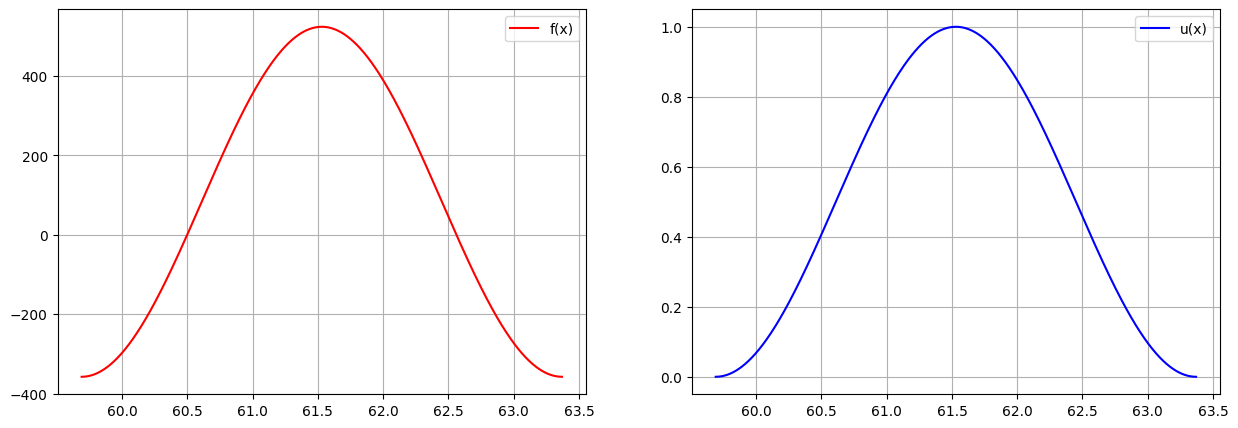

In [310]:
def u(x): return np.pow(np.sin(np.pi * (x - b) / (b - a)), 2)
def du(x): return np.pi * np.sin(2 * np.pi * (x - b) / (b - a)) / (b - a)
def ddu(x): return 2 * np.pow(np.pi, 2) * np.cos(2 * np.pi * (x - b) / (b - a)) / np.pow(b - a, 2)
def f(x): return -p*ddu(x) + q*u(x)


fig, axs = plt.subplots(1, 2, figsize=(15, 5))
x = np.linspace(a, b, 1000)
axs[0].plot(x, f(x), label='f(x)', color='red')
axs[1].plot(x, u(x), label='u(x)', color='blue')
axs[0].legend()
axs[1].legend()
axs[0].grid()
axs[1].grid()

plt.show()

1. Составление разностной схемы МКЭ без явного создания матрицы А.

In [311]:
def funvect(func, n):
    n += 1
    x, h = np.linspace(a, b, n+1, retstep=True)
    xfunc = lambda x: x*func(x)
    vect = np.zeros(n-1)

    for i in range(1, n):
        vect[i-1] = quad(xfunc, x[i-1], x[i])[0] - x[i-1]*quad(func, x[i-1], x[i])[0] + x[i+1]*quad(func, x[i], x[i+1])[0] - quad(xfunc, x[i], x[i+1])[0]
    return 1*np.power(h, -2)*vect

def FEMoperator(vect):
    h = (b-a) / vect.size

    mtr1, mtr2 = np.zeros_like(vect), np.zeros_like(vect)
    mtr1[:] += 2*vect
    mtr1[1:] -= vect[:-1]
    mtr1[:-1] -= vect[1:]

    mtr2[:] += 4*vect
    mtr2[1:] += vect[:-1]
    mtr2[:-1] += vect[1:]

    return p/(h**2) * mtr1 + q/6 * mtr2

def createOperator(n):
    return LinearOperator((n, n), matvec=FEMoperator)

def diagFromOperator(A: LinearOperator):
    n = A.shape[0]
    mtr = np.zeros((3, n))
    mtr[0, 1:] = np.array([A.matvec(np.eye(n)[:, i])[i+1] for i in range(n-1)])     # upper
    mtr[1, :] = np.array([A.matvec(np.eye(n)[:, i])[i] for i in range(n)])          # main
    mtr[2, :-1] = np.array([A.matvec(np.eye(n)[:, i])[i-1] for i in range(1, n)])   # lower
    return mtr

print(diagFromOperator(createOperator(5)))

[[   0.         -425.05295546 -425.05295546 -425.05295546 -425.05295546]
 [1016.16755199 1016.16755199 1016.16755199 1016.16755199 1016.16755199]
 [-425.05295546 -425.05295546 -425.05295546 -425.05295546    0.        ]]


2. Итерационный метод Зейделя, работающий с оператором, реализующим матрично-векторное умножение.

In [312]:
def SeidelMethod(lin_op, vct, x0, maxit = None, eps=1e-9):
    n = len(vct)
    if maxit is None:
        maxit = n*10
    
    x = x0.copy()
    xp = np.zeros_like(x)
    
    for _ in range(maxit):
        for i in range(n):
            e_i = np.zeros(n)
            e_i[i] = 1
            row = lin_op @ e_i
            
            s1 = np.dot(row[:i], x[:i])
            s2 = np.dot(row[i+1:], xp[i+1:])
            x[i] = (vct[i] - s1 - s2) / row[i]
        
        if np.linalg.norm(x - xp, ord=np.inf) <= eps:
            break
        
        xp = x.copy()
    
    return x

ktest = 5
Atest = createOperator(ktest)
Mtest = diagFromOperator(Atest)
vtest = np.random.uniform(1, 10, ktest)
print(f'Operator solution: {SeidelMethod(Atest, vtest, vtest)}')
print(f'Matrix solution: {solve_banded((1, 1), Mtest, vtest)}')

Operator solution: [0.01359971 0.02459443 0.02804542 0.02358958 0.01224665]
Matrix solution: [0.01359971 0.02459443 0.02804542 0.02358958 0.01224665]


3. Реализация MGMV, операторов проекции, продолжения.

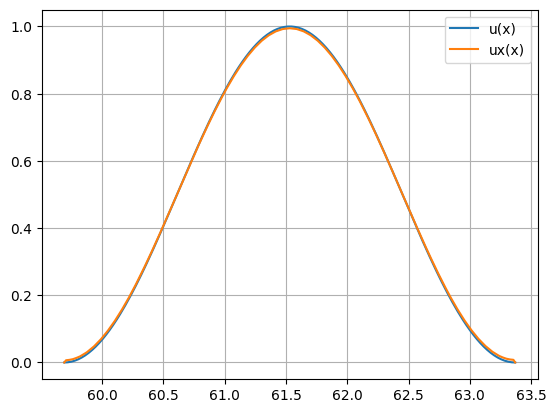

Time: 0.30707026


In [313]:
def C(x):
    xc = np.zeros(2*x.size - 1)
    xc[::2] = x
    xc[1::2] = 0.5 * xc[:-2:2] + 0.5 * xc[2::2]
    return xc

def P(x):
    xp = np.zeros(x.size // 2 + 1)
    xp[1:-1] = 0.25*x[1:-2:2] + 0.5*x[2:-1:2] + 0.25*x[3::2]
    xp[0] = 0.75*x[0] + 0.25*x[1]
    xp[-1] = 0.75*x[-1] + 0.25*x[-2]
    return xp

def MGM(x, b, nu):
    n = x.size
    A = createOperator(n)
    xnu = SeidelMethod(A, b, b, maxit=nu)
    r = P(b - A(xnu))
    return xnu, r, np.zeros(r.size)


def MGMV(k, x, b, nu, post = False):
    n = x.size
    A = createOperator(n)
    if k == 0: 
        return solve_banded((1, 1), diagFromOperator(A), b)
        
    if post: 
        pnu = nu // 2
    else:    
        pnu = nu

    xnu, r, e = MGM(x, b, pnu)
    e1 = MGMV(k-1, e, r, nu)
    e = np.copy(e1)
    xnu += C(e)

    if post:
        xnu = SeidelMethod(A, b, xnu, pnu)

    return xnu


def solver(k, x, b, nu, post = False):
    alpha1 = np.zeros(x.size)
    start = time.time()
    while True:
        alpha = MGMV(k, alpha1, b, nu, post)
        nalpha = np.linalg.norm(alpha - alpha1, ord=2)
        if nalpha < 1e-3:
            break
        alpha1 = alpha.copy()
    end = time.time()
    return alpha, np.round(end - start, 8)

n = 257
xarr = np.linspace(a, b, n+2)
ux, t = solver(2, np.zeros(n), funvect(f, n), 20)
ux = np.array([0.0] + ux.tolist() + [0.0])

plt.plot(xarr, u(xarr), label='u(x)')
plt.plot(xarr, ux, label='ux(x)')
plt.legend()
plt.grid()
plt.show()
print(f'Time: {t}')


4. Заполнение таблицы для n = { 4096, 2048, 1024, 512, 256 }

In [286]:
k = np.int64(np.linspace(1, 10, 10))
nu = np.int64(np.linspace(10, 100, 10))
dims = np.array([np.pow(2, i) + 1 for i in range(8, 13)], dtype=np.int64)[::-1]
tdict = {n: pd.DataFrame(np.nan, index=k, columns=nu) for n in dims[::-1]}

def tableFiller():
    for i, df in enumerate(list(tdict.values())[:3]):
        for j, kv in enumerate(k[:7+i]):
            for m, nuv in enumerate(nu):
                df.iloc[j, m] = solver(kv, np.zeros(dims[-1-i]), funvect(f, dims[-1-i]), nuv)[1]
                print(f'end {dims[-1-i]} {kv} {nuv} {df.iloc[j, m]}s')

    for i, df in enumerate(list(tdict.values())[-2:]):
        for j, kv in enumerate(k):
            for m, nuv in enumerate(nu):
                df.iloc[j, m] = solver(kv, np.zeros(dims[i]), funvect(f, dims[i]), nuv)[1]
                print(f'end {dims[i]} {kv} {nuv} {df.iloc[j, m]}s')

tableFiller()

end 257 1 10 0.11702704s
end 257 1 20 0.21605396s
end 257 1 30 0.31634355s
end 257 1 40 0.42509627s
end 257 1 50 0.51608968s
end 257 1 60 0.62014771s
end 257 1 70 0.73045969s
end 257 1 80 0.81017089s
end 257 1 90 0.91221499s
end 257 1 100 1.01179934s
end 257 2 10 0.15812898s
end 257 2 20 0.30606937s
end 257 2 30 0.45510268s
end 257 2 40 0.60513711s
end 257 2 50 0.75036168s
end 257 2 60 0.90321016s
end 257 2 70 1.05261064s
end 257 2 80 1.19827652s
end 257 2 90 1.35116625s
end 257 2 100 1.49780512s
end 257 3 10 0.17904043s
end 257 3 20 0.35107899s
end 257 3 30 0.52711868s
end 257 3 40 0.6984489s
end 257 3 50 0.87120247s
end 257 3 60 1.0602448s
end 257 3 70 1.2254138s
end 257 3 80 1.39632082s
end 257 3 90 1.56535506s
end 257 3 100 1.73840761s
end 257 4 10 0.19004273s
end 257 4 20 0.37308669s
end 257 4 30 0.56113434s
end 257 4 40 0.74717784s
end 257 4 50 0.92821097s
end 257 4 60 1.110255s
end 257 4 70 1.30053854s
end 257 4 80 1.4816792s
end 257 4 90 1.66707873s
end 257 4 100 1.85302019s
en

In [292]:
tdict[257]

,10,20,30,40,50,60,70,80,90,100
1,0.117027,0.216054,0.316344,0.425096,0.516090,0.620148,0.730460,0.810171,0.912215,1.011799
2,0.158129,0.306069,0.455103,0.605137,0.750362,0.903210,1.052611,1.198277,1.351166,1.497805
3,0.179040,0.351079,0.527119,0.698449,0.871202,1.060245,1.225414,1.396321,1.565355,1.738408
4,0.190043,0.373087,0.561134,0.747178,0.928211,1.110255,1.300539,1.481679,1.667079,1.853020
5,0.194044,0.394089,0.619139,0.769179,0.976227,1.151438,1.344358,1.544354,1.722670,1.937438
6,0.199045,0.392088,0.589133,0.781177,0.977221,1.175267,1.365309,1.559353,1.753398,1.934438
7,0.201046,0.396091,0.592134,0.784179,0.979225,1.176266,1.364308,1.557353,1.742269,1.933440
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [293]:
tdict[513]

,10,20,30,40,50,60,70,80,90,100
1,0.258058,0.473107,0.686156,0.899204,1.113252,1.322300,1.541348,1.769401,1.963444,2.178496
2,0.328074,0.643152,0.954221,1.266282,1.584370,1.911380,2.228961,2.522142,2.833843,3.140334
3,0.373085,0.734167,1.112261,1.456548,1.816789,2.181513,2.538910,2.903919,3.263411,3.615429
4,0.389088,0.775182,1.160331,1.547363,1.930450,2.312966,2.699885,3.099768,3.479366,3.855903
5,0.401091,0.799181,1.196781,1.593857,1.992455,2.390635,2.788793,3.240055,3.600203,3.978827
6,0.407092,0.819186,1.218342,1.619367,2.023459,2.429868,2.835642,3.239526,3.639275,4.063254
7,0.411141,0.817185,1.225660,1.635376,2.037848,2.468173,2.861018,3.261175,3.658258,4.068680
8,0.413094,0.822479,1.230490,1.635610,2.040963,2.448137,2.855415,3.253136,3.674393,4.057232
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [294]:
tdict[1025]

,10,20,30,40,50,60,70,80,90,100
1,1.270869,1.735399,2.178686,2.639114,3.088851,3.538538,3.996828,4.453930,4.910928,5.353236
2,0.711507,1.381946,2.051065,2.725029,3.390163,4.043197,4.731974,5.414191,6.056124,6.725216
3,0.784177,1.549351,2.322074,3.177418,3.848867,4.775461,5.386904,6.145377,6.927589,7.678113
4,0.823186,1.639371,2.459557,3.264739,4.085330,4.976310,5.715049,6.538028,7.363746,8.175586
5,0.843191,1.691771,2.526734,3.361473,4.209061,5.063468,5.880047,6.718449,7.590061,8.412514
6,0.856198,1.728406,2.559965,3.414117,4.270682,5.120382,5.966540,6.824941,7.695893,8.531793
7,0.864321,1.722578,2.582601,3.430518,4.300511,5.175052,6.022148,6.869907,7.735380,8.594992
8,0.883205,1.725517,2.608602,3.452795,4.319188,5.176932,6.034142,6.902280,7.751419,8.608414
9,0.867495,1.732656,2.672709,3.463156,4.327639,5.194176,6.036373,6.919887,7.758726,8.622719
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [295]:
tdict[2049]

,10,20,30,40,50,60,70,80,90,100
1,52.313936,54.096163,56.670417,59.282781,62.636083,65.051616,66.941224,69.421142,73.221200,75.510296
2,14.116355,17.690266,21.359346,24.987460,28.646307,32.242241,35.901456,39.903177,43.499202,46.817982
3,5.135476,9.191002,13.327491,17.359771,21.442492,25.576894,29.625118,33.804411,37.985224,42.011807
4,4.345985,8.685957,12.960685,17.279615,21.613654,25.885029,30.230128,34.522623,38.895091,43.298795
5,4.426011,8.828364,13.323575,17.649174,22.056431,26.445848,31.070183,35.359620,39.631773,44.081448
6,4.530739,8.916568,13.385956,17.850536,22.378531,26.766449,31.212328,35.681916,40.132472,44.556968
7,4.481409,9.008963,13.445122,18.034292,22.433467,27.006915,31.406426,35.882859,40.430072,44.880429
8,4.498554,8.998122,13.497743,17.985141,22.595005,26.971852,31.556266,35.991241,40.426929,44.923091
9,4.505730,9.004465,13.507195,17.991442,22.526022,27.028038,31.604454,36.272797,40.542129,44.996219
10,4.508641,8.999755,13.531692,18.040789,22.560335,27.082827,31.557153,36.147307,40.642881,45.065266


In [291]:
tdict[4097]

,10,20,30,40,50,60,70,80,90,100
1,11.543416,12.603090,13.667708,14.747967,15.805688,16.872694,17.892059,18.984997,20.090712,21.115805
2,2.506883,4.155962,5.525523,7.099751,8.636294,10.140031,11.674786,13.310685,14.748593,16.178345
3,1.782825,3.521811,5.251927,7.014531,8.713690,10.482587,12.209041,13.936030,15.665023,17.388785
4,1.852431,3.689699,5.534761,7.372457,9.190297,11.023730,12.908789,14.701062,16.563446,18.446689
5,1.893439,3.803862,5.658785,7.553058,9.411648,11.414304,13.182010,15.102497,16.966887,18.881661
6,1.914877,3.826213,5.735849,7.642057,9.573396,11.459204,13.384176,15.285072,17.186897,19.091141
7,1.926676,3.848309,5.764418,7.704989,9.601605,11.521078,13.535158,15.363549,17.310203,19.292703
8,1.933810,3.849406,5.838606,7.736870,9.641894,11.584280,13.481670,15.450105,17.334663,19.297925
9,1.934447,3.866222,5.797460,7.725231,9.677040,11.587869,13.543296,15.458367,17.389181,19.436047
10,1.937439,3.876290,5.909130,7.750526,9.679311,11.603906,13.529903,15.552081,17.391145,19.335540


5. Сравнить с временем выполнения метода Зейделя

In [320]:
n = 257
xarr = funvect(f, n)
start = time.time()
ux = SeidelMethod(createOperator(n), xarr, xarr)
end = time.time()
print(f'Estimated time of SeidelMeth: {end-start}')
print(f'Estimated time of MGMV: {tdict[n].min().min()}')

Estimated time of SeidelMeth: 12.752447366714478
Estimated time of MGMV: 0.11702704


6. Модификация метода MGMV постсглаживанием

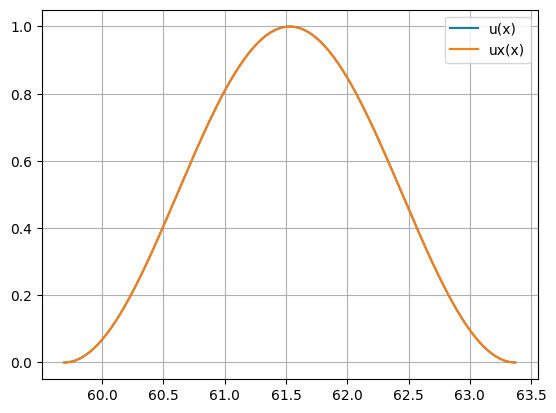

N: 4097, k: 2, nu: 20
Time: 18.62063503


In [317]:
xarr = np.linspace(a, b, n+2)
tk = 2
tnu = 20
ux, t = solver(tk, np.zeros(n), funvect(f, n), tnu)
ux = np.array([0.0] + ux.tolist() + [0.0])

plt.plot(xarr, u(xarr), label='u(x)')
plt.plot(xarr, ux, label='ux(x)')
plt.legend()
plt.grid()
plt.show()
print(f'N: {n}, k: {tk}, nu: {tnu}')
print(f'Time: {t}')